In [1]:
import os, gzip
import matplotlib.pyplot as plt
import pysam

import lakeview as lv

plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 100

## Download BAM files

In [2]:
CHROMOSOME = "chr14"
START = 104586347
END = 107043718
REGION = f"{CHROMOSOME}:{START}-{END}"


PACBIO_BAM_URL = "ftp://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/AshkenazimTrio/HG002_NA24385_son/PacBio_CCS_15kb_20kb_chemistry2/GRCh38/HG002.SequelII.merged_15kb_20kb.pbmm2.GRCh38.haplotag.10x.bam"
PACBIO_BAI_URL = "ftp://ftp-trace.ncbi.nlm.nih.gov/ReferenceSamples/giab/data/AshkenazimTrio/HG002_NA24385_son/PacBio_CCS_15kb_20kb_chemistry2/GRCh38/HG002.SequelII.merged_15kb_20kb.pbmm2.GRCh38.haplotag.10x.bam.bai"
PACBIO_BAM_PATH = "data/PacBio_CCS.bam"
PACBIO_BAI_PATH = "data/PacBio_CCS.bam.bai"

lv.helpers.download_bam(PACBIO_BAM_URL, PACBIO_BAI_URL, REGION, PACBIO_BAM_PATH)

## Download GTF file

In [3]:
GENCODE_GTF_URL = "https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_41/gencode.v41.annotation.gtf.gz"
GENCODE_GTF_PATH = "data/gencode.v40.annotation.gtf.gz"
if not os.path.isfile(GENCODE_GTF_PATH):
    !wget {GENCODE_GTF_URL} -O {GENCODE_GTF_PATH}

## Load data

In [4]:
pacbio_painter = lv.SequenceAlignment.from_file(PACBIO_BAM_PATH, "rb")

In [40]:
with gzip.open(GENCODE_GTF_PATH, "rt") as f:
    gencode_painter = lv.GeneAnnotation.from_file(
        file_object=f,
        format="gtf",
        sequence_name=CHROMOSOME,
        start=START,
        end=END,
    )
gencode_painter.transcripts.sort(key=len, reverse=True)

## Plotting

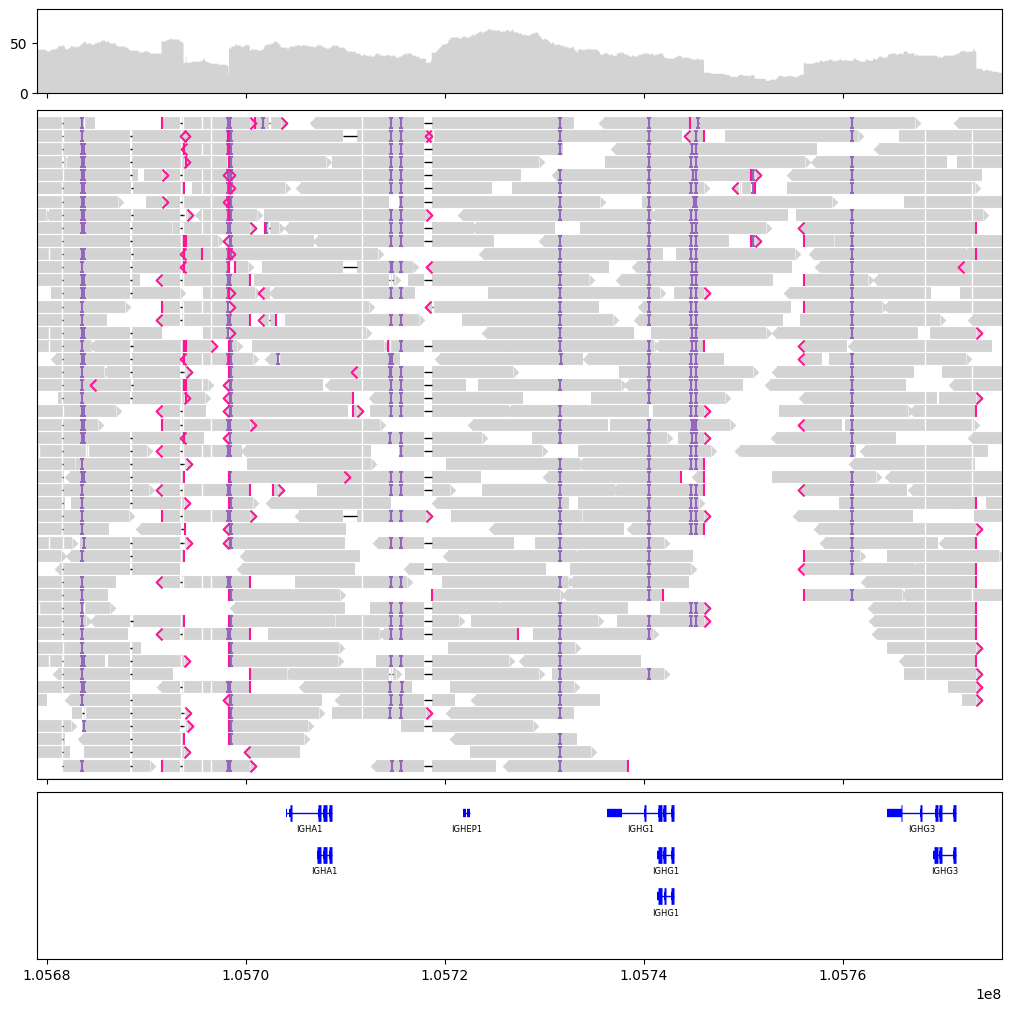

In [28]:
plt.ioff()
gv = lv.GenomeViewer(3, height_ratios=(1, 8, 2))
pacbio_painter.draw_pileup(
    gv.axes[0],
    show_mismatches=False,
)
pacbio_painter.draw_alignment(
    gv.axes[1],
    show_mismatches=False,
    order=lambda seg: -seg.query_alignment_length,
    max_depth=50,
)
gencode_painter.draw_transcripts(gv.axes[2], max_group_depth=4, labels=lambda t: t.attributes['gene_name'])

gv.set_xlim((105679000, 105776000))
gv.figure

### Test linked segments

In [4]:
pacbio_painter = lv.SequenceAlignment.from_file(PACBIO_BAM_PATH, "rb", load_pileup=False)

(105400000.0, 106800000.0)

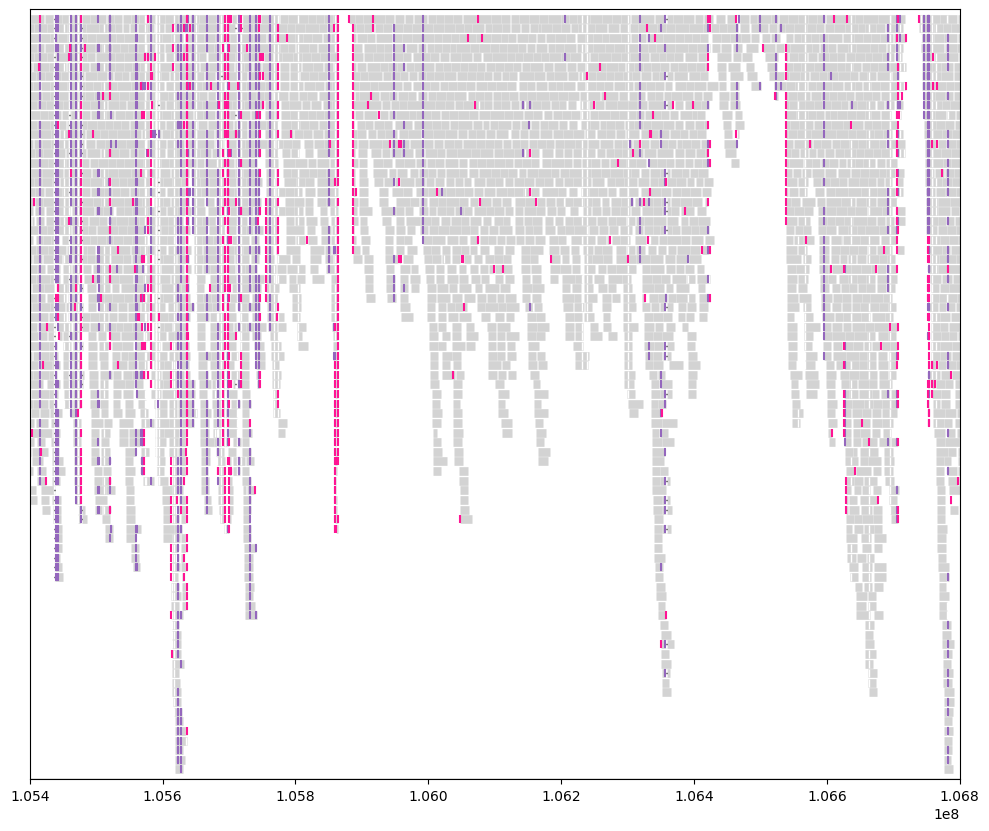

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))
pacbio_painter.draw_alignment(ax, show_mismatches=False, show_arrowheads=False)
ax.set_xlim(105_400_000, 106_800_000)

/workspace/lakeview/src/lakeview/widget.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(
/workspace/lakeview/src/lakeview/widget.py:54: UserWarning: Backend ipympl not activated. Current backend: module://matplotlib_inline.backend_inline. To enable additional interactive functionality, please activate ipympl using `%matplotlib widget`.
  warn(


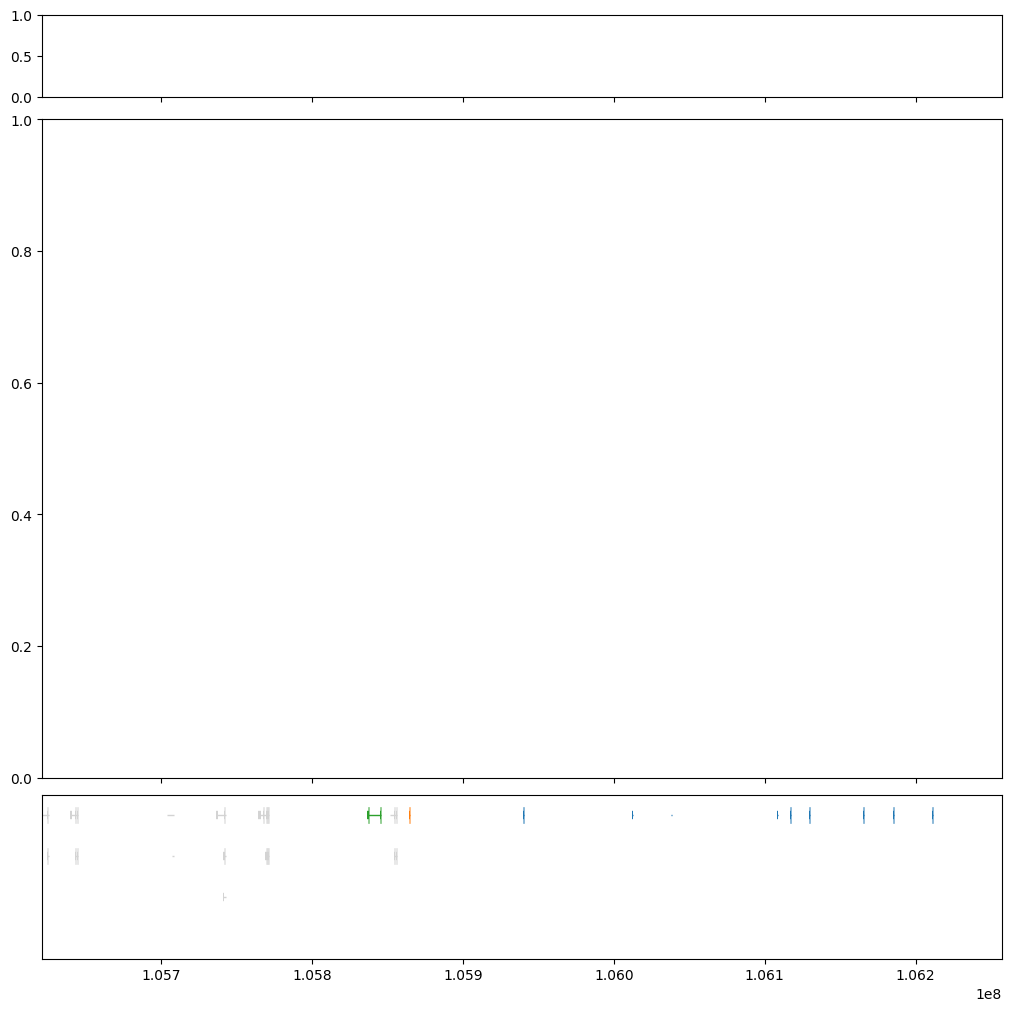

In [42]:
plt.ioff()
gv = lv.GenomeViewer(3, height_ratios=(1, 8, 2))

color_dict = dict(IGHV="tab:blue", IGHD="tab:green", IGHJ="tab:orange", IGHC="tab:red")
gencode_painter.transcripts = list(
    filter(
        lambda t: t.attributes["gene_type"]
        in ("IG_C_gene", "IG_D_gene", "IG_V_gene", "IG_J_gene", 'protein_coding'),
        gencode_painter.transcripts,
    )
)
transcript_colors = [
    color_dict.get(t.attributes["gene_name"][:4], 'lightgray') for t in gencode_painter.transcripts
]

gencode_painter.draw_transcripts(
    gv.axes[2], max_group_depth=4, colors=transcript_colors, labels=lambda t: ""
)

gv.set_xlim((105_620_914, 106_257_000))
# chr14:105,839,433-105,891,432
gv.figure
